# global variables

In [2]:
# sneaky global variable !!!!!

# bump this version every time new install is added/removed/modified
gl_latest_env_version = "1.0.3";

# dataset root
gl_dataset_directory = "dataset/";

# weight root
gl_weight_directory = "weights/";

# training/validation/testing file location
gl_training_file = gl_dataset_directory + "train.p";
gl_validation_file = gl_dataset_directory + "valid.p";
gl_testing_file = gl_dataset_directory + "test.p";

# environment setup

In [3]:
def install_env_wrapper() -> None:
    """
    Update environment and throw error if not already installed.

    This is a standalone function, doesn't require external import.
    """
    env_result = install_env(gl_latest_env_version);
    if (env_result != True):
        print("Changes might not apply immediately, restart runtime to apply changes.");
        assert(False); # force error

def install_env(latest_version: str) -> bool | None:
    """
    Return true if already installed, false if not, None (or error) if error.
    """
    import os;
    import shutil;

    env_file = "env.txt";
    env_version = "0.0.0"; # default version
    if os.path.isfile(env_file):
        with open(env_file, "r") as f:
            version = f.readline()[:-1];
            env_version = version;
    else:
        with open(env_file, "x") as f:
            f.write(env_version + "\n");

    if env_version == gl_latest_env_version:
        print("version matched, install skipped.");
        return True;

    print("installing package...");
    install_package("notebook");
    install_package("jupyter");
    install_package("tensorflow");
    install_package("keras");
    install_package("pandas");
    install_package("matplotlib");

    if in_colab():
        if os.path.isdir("drive"):
            print("drive already mounted.");
        else:
            print("mounting drive...");
            from google.colab import drive;
            drive.mount("./drive", force_remount=False);

    if os.path.isdir(gl_dataset_directory):
        print(gl_dataset_directory + " is up to date.");
    else:
        if in_colab():
            print("setup dataset...");
            srcpath = "./drive/MyDrive/autonomous_project2/" + gl_dataset_directory;
            shutil.copytree(src=srcpath,
                            dst=gl_dataset_directory);
        else:
            os.mkdir(gl_dataset_directory);
            print(gl_dataset_directory + " not found, please manually place it.");
            return None;

    if os.path.isdir(gl_weight_directory):
        print(gl_weight_directory + " is up to date.");
    else:
        if in_colab():
            srcpath = "./drive/MyDrive/autonomous_project2/" + gl_dataset_directory;
            if not os.path.isdir(srcpath):
                print("creating " + srcpath + "...");
                os.mkdir(srcpath);
            else:
                print("creating " + gl_weight_directory + "...");
                os.mkdir(gl_weight_directory);
            print("setup weight...");
            shutil.copytree(src=srcpath,
                            dst=gl_dataset_directory);
        else:
            print("creating " + gl_weight_directory + "...");
            os.mkdir(gl_weight_directory);

    with open(env_file, "w") as f:
        f.write(gl_latest_env_version + "\n");
    print("version updated");
    return False;

def in_colab() -> bool:
    import importlib.util;
    return importlib.util.find_spec("google.colab") is not None;

def install_package(package_name: str) -> None:
    """
    Automatically install package.
    """
    import importlib.util;
    import subprocess;
    if importlib.util.find_spec(package_name):
        command = ["pip", "install", package_name];
        print("installing "+ package_name + "...");
        proc = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT);
        _ = proc.communicate(input='y'.encode())[0];

# import

In [4]:
import numpy as np;

import pickle;

import keras;
from keras.src.models.model import Model;
from keras.src.optimizers.optimizer import Optimizer;

import matplotlib.pyplot as plt;

from typing import Callable, Any;

# functions

## load dataset

In [5]:
def loadDataset(usage):
    if usage == "train":
        use_file = gl_training_file;
    elif usage == "valid":
        use_file = gl_validation_file;
    elif usage == "test":
        use_file = gl_testing_file;
    else:
        raise ValueError;
    with open(use_file, mode="rb") as f:
        dataset = pickle.load(f);
    return dataset["features"], dataset["labels"];

## preprocess data

In [6]:
def preprocess(X: np.ndarray, Y: np.ndarray, num_classes: int | None) -> tuple[np.ndarray, np.ndarray]:
    if num_classes is None:
        num_classes = len(np.unique(Y));
    Y_OneHot = keras.utils.to_categorical(Y, num_classes=num_classes);
    Y_Reshape = Y_OneHot.reshape((-1, 1, 1, num_classes));

    return X, Y_Reshape;

## define model

In [7]:
def Lenet(n_classes: int) -> Model:
    model = keras.Sequential();
    model.add(keras.layers.BatchNormalization());
    model.add(keras.layers.Conv2D(6, (5, 5), activation=keras.activations.tanh));
    model.add(keras.layers.MaxPooling2D((2, 2)));
    model.add(keras.layers.Conv2D(16, (5, 5), activation=keras.activations.tanh));
    model.add(keras.layers.MaxPooling2D((2, 2)));
    model.add(keras.layers.Conv2D(120, (5, 5), activation=keras.activations.tanh));

    model.add(keras.layers.Dense(84, activation=keras.activations.tanh));
    model.add(keras.layers.Dense(n_classes, activation=keras.activations.softmax));
    return model;

In [21]:
def getModel(model_fn: Callable[[int], Model], n_classes: int, optimizer: Optimizer) -> Model:
    model: Model = model_fn(n_classes=n_classes);
    model.compile(optimizer=optimizer,
                loss=keras.losses.CategoricalCrossentropy(),
                run_eagerly=False,
                metrics=[
                    keras.metrics.Accuracy(),
                ],
                );
    return model;

## train, evaluate and test

In [14]:
def trainModel(model: Model, x_train, y_train, x_valid, y_valid, batch_size: int, epochs: int) -> Any:
    return model.fit(x=x_train,
                     y=y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(x_valid, y_valid),
                     );

def testModel(model: Model, x_test, y_test, batch_size: int) -> Any:
    return model.evaluate(x=x_test,
                          y=y_test,
                          batch_size=batch_size,
                          );

def predictModel(model: Model, x_test) -> np.ndarray:
    return model.predict(x=x_test,
                         batch_size=1,
                         );

## save and load weight

In [15]:
def saveWeight(model: Model, filename: str) -> None:
    filepath = gl_weight_directory + filename + ".weights.h5";
    model.save_weights(filepath=filepath, overwrite=True);

def loadWeight(model: Model, filename: str) -> None:
    filepath = gl_weight_directory + filename + ".weights.h5";
    model.load_weights(filepath=filepath, skip_mismatch=False);

## test inference image

In [16]:
def getSignNames() -> np.ndarray:
    import pandas;
    df = pandas.read_csv('./signnames.csv')['SignName'];
    return df.to_numpy();

In [17]:
# Load the images and plot them here.
def inference(sign_names: np.ndarray, model: keras.models.Sequential) -> None:
    import matplotlib.image as mpimg;
    NImages = 10
    X_real = np.zeros((NImages,32,32,3)).astype(np.uint8);
    y_real = np.array([17,12,14,11,38,4,35,33,25,13]);
    prediction = predictModel(model, X_real);
    prediction = prediction.reshape((NImages, -1));
    prediction_class = np.argmax(prediction, axis=1);
    prediction_value = np.max(prediction, axis=1);

    for i in range(NImages):
        image = mpimg.imread('./testImages/'+str(i+1)+'.png');
        image = np.multiply(image,256).astype(np.uint8)[:,:,0:3];
        X_real[i] = image;
        printfmt = "predicted class = {} ({}), value={:.4f}\nactual class = {} ({})."
        printstring = printfmt.format(prediction_class[i],
                                      sign_names[prediction_class[i]],
                                      prediction_value[i],
                                      y_real[i],
                                      sign_names[y_real[i]],
                                      );
        print(printstring);
    for i in range(NImages):
        plt.figure(figsize=(1,1));
        plt.imshow(X_real[i]);
        plt.show();


# main function

In [18]:
gl_history = None;

In [19]:
def main() -> None:
    """
    main function
    """
    # start
    print("main begin");

    # hyperparameters
    batch_size = 16;
    epochs = 10;

    # do final test or not
    do_final_test = True;

    # load dataset
    X_train_raw, Y_train_raw = loadDataset("train");
    X_valid_raw, Y_valid_raw = loadDataset("valid");
    X_test_raw, Y_test_raw = loadDataset("test");

    # preprocess dataset
    num_classes = len(np.unique(Y_train_raw)); # 43
    X_train, Y_train = preprocess(X_train_raw, Y_train_raw, num_classes);
    X_valid, Y_valid = preprocess(X_valid_raw, Y_valid_raw, num_classes);
    X_test, Y_test = preprocess(X_test_raw, Y_test_raw, num_classes);

    # get model
    sgd = keras.optimizers.SGD(learning_rate=0.01);
    adam = keras.optimizers.Adam(learning_rate=0.001);
    model = getModel(model_fn=Lenet, n_classes=num_classes, optimizer=sgd);

    # train model
    history = trainModel(model, X_train, Y_train, X_valid, Y_valid, batch_size, epochs);
    global gl_history;
    gl_history = history;

    # save weight(optional)
    saveWeight(model, "lenet_v1");

    # evaluate model
    print("=====evaluate model result:======");
    testModel(model, X_valid, Y_valid, batch_size);
    print("=================================");

    # test model
    if do_final_test:
        print("=======test model result:=======");
        testModel(model, X_test, Y_test, batch_size);
        print("================================");

    # inference
    if do_final_test:
        sign_names = getSignNames();
        inference(sign_names=sign_names, model=model);

    # finish
    print("main end");

version matched, install skipped.
main begin
Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.0000e+00 - loss: 2.4221 - val_accuracy: 0.0000e+00 - val_loss: 0.7508
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0000e+00 - loss: 0.5344 - val_accuracy: 0.0000e+00 - val_loss: 0.4209
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0000e+00 - loss: 0.2858 - val_accuracy: 0.0000e+00 - val_loss: 0.3199
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.0000e+00 - loss: 0.1833 - val_accuracy: 0.0000e+00 - val_loss: 0.2592
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.0000e+00 - loss: 0.1337 - val_accuracy: 0.0000e+00 - val_loss: 0.2401
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0000e+00 - loss: 0.1011 - val_accuracy: 0.0000e+00 - val_loss: 0.2113
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0781 - val_accuracy: 0.0000e+00 -

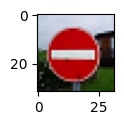

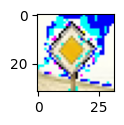

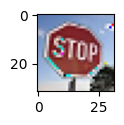

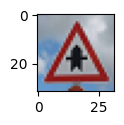

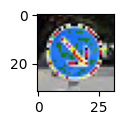

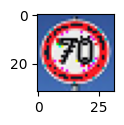

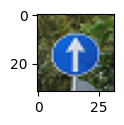

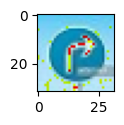

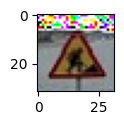

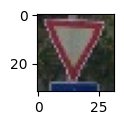

main end


In [22]:
if __name__ == "__main__":
    install_env_wrapper();
    main();